# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

In [ ]:
!git clone https://github.com/MadaneA/MACS3-Statistiques-Descriptives-TDs.git

In [15]:
import os
os.chdir('../MACS3-Statistiques-Descriptives-TDs')

In [17]:
import pandas as pd
import numpy as np

# Charger les données à partir du fichier Excel
acars_data = pd.read_excel("./data/accars_b.xlsx")

# Explorer les propriétés générales du jeu de données
print("Aperçu des premières lignes du jeu de données :")
print(acars_data.head())

print("\nInformations sur les types de données et les valeurs non nulles :")
print(acars_data.info())

print("\nStatistiques descriptives du jeu de données :")
print(acars_data.describe())



Aperçu des premières lignes du jeu de données :
  flight_phase  engine_number  engine_type  aircraft_number  engine_position  \
0        CLIMB            186           10              192                1   
1        CLIMB            186           10              192                1   
2        CLIMB            186           10              192                1   
3        CLIMB            186           10              192                1   
4        CLIMB            186           10              192                1   

  airline_classif_environment  brat    cas  cycles   delfn  ...  ztoil  zvb1f  \
0                     Neutral   1.0  151.0     6.0 -0.1146  ...   88.0   0.57   
1                     Neutral   1.0  143.0     7.0 -0.2464  ...   90.8   0.58   
2                     Neutral   1.0  163.0     8.0     NaN  ...   89.0   0.28   
3                     Neutral   1.0  152.0     9.0     NaN  ...   87.0   0.44   
4                     Neutral   1.0  154.0    10.0     NaN  ...   

#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

In [33]:

# Vérifier s'il y a des valeurs manquantes dans le DataFrame
missing_values = acars_data.isna().sum()

missing_values


flight_phase                       0
engine_number                      0
engine_type                        0
aircraft_number                    0
engine_position                    0
airline_classif_environment      484
brat                               4
cas                            11920
cycles                         30553
delfn                            584
deln1                            584
dtamb                            584
egthdm                          1351
iai                                4
iaie1                            308
iaie2                            308
iaiwg                              4
ibe1                               0
ibe2                               0
ivs12                              0
pcn1k                           1351
sloatl                          1351
tsih                           32885
vbvpos                         27236
wbe                            36699
yn1mod                             4
zalt                              34
z

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [36]:
# Filtrer les lignes où 'cycles' et 'egthdm' ne sont pas manquants
acars_data_filtre = acars_data.dropna(subset=['cycles', 'egthdm'])

# Afficher les premières lignes du DataFrame filtré
print(acars_data_filtre.head())




    flight_phase  engine_number  engine_type  aircraft_number  \
104      TAKEOFF            186           10              192   
105      TAKEOFF            186           10              192   
106      TAKEOFF            186           10              192   
107      TAKEOFF            186           10              192   
108      TAKEOFF            186           10              192   

     engine_position airline_classif_environment  brat   cas  cycles    delfn  \
104                1                     Neutral   0.0  88.0     5.0  23.8191   
105                1                     Neutral   0.0  93.0     6.0  25.4038   
106                1                     Neutral   0.0  92.0     7.0  22.7509   
107                1                     Neutral   0.0  87.0     8.0  22.1533   
108                1                     Neutral   0.0  88.0     9.0  23.8673   

     ...  ztoil  zvb1f  zvb1r  zvb2f  zvb2r  zvsv  zwbp1  zwbp2  zwf36    zxm  
104  ...   84.3   0.39   0.58   0.05   0.1

#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [37]:
# Afficher les différents types de moteurs
types_moteurs = acars_data['engine_type'].unique()
print(types_moteurs)


[10  5  7]


#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [63]:


# Sélectionner uniquement les moteurs de type 10
moteurs_type_10 = acars_data[acars_data['engine_type'] == 10]

# Grouper par 'aircraft' et compter le nombre de vols par avion
nombre_vols_par_avion = moteurs_type_10.groupby('aircraft_number').size()

# Afficher le nombre de vols par avion de moteurs de type 10
print("Nombre de vols par avion de moteurs de type 10 :\n", nombre_vols_par_avion)





Nombre de vols par avion de moteurs de type 10 :
 aircraft_number
11      68
14     242
190    552
191     24
192    516
dtype: int64


## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [68]:
# Sélectionner les données pour l'avion numéro 190
avion_190_data = acars_data.loc[acars_data['aircraft_number'] == 190, ['engine_number', 'cycles', 'egthdm']]

# Afficher les données de l'avion numéro 190
print("Données pour l'avion numéro 190 :\n", avion_190_data)


Données pour l'avion numéro 190 :
        engine_number  cycles   egthdm
11300            179     7.0      NaN
11301            179    31.0      NaN
11302            180    89.0      NaN
11303            180   191.0      NaN
11398            179    98.0  52.0118
...              ...     ...      ...
46318            179   102.0      NaN
46319            179   142.0      NaN
46320            180     5.0      NaN
46411            179    30.0  56.5585
46412            179   101.0  41.0874

[552 rows x 3 columns]


#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

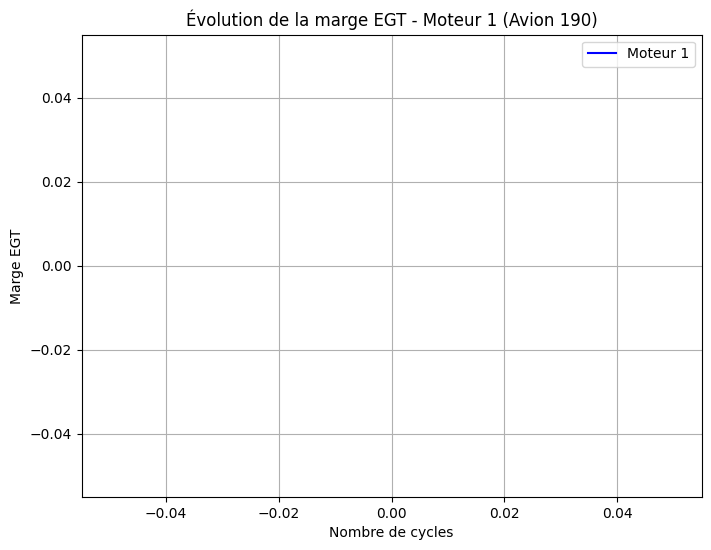

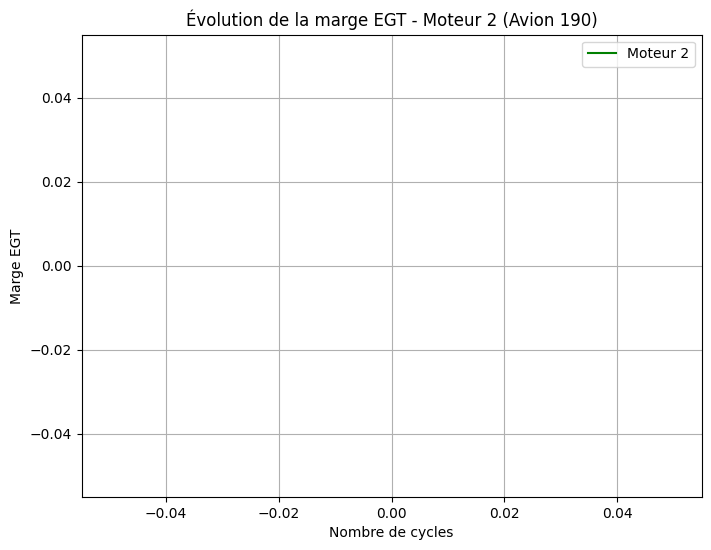

In [73]:
import matplotlib.pyplot as plt

# Les 2 moteurs de l'avion 190
moteur1_data = avion_190_data.loc[avion_190_data['engine_number'] == 1, ['cycles', 'egthdm']]
moteur2_data = avion_190_data.loc[avion_190_data['engine_number'] == 2, ['cycles', 'egthdm']]

# Graphique pour le moteur 1
plt.figure(figsize=(8, 6))
plt.plot(moteur1_data['cycles'], moteur1_data['egthdm'], label='Moteur 1', color='blue')
plt.xlabel('Nombre de cycles')
plt.ylabel('Marge EGT')
plt.title('Évolution de la marge EGT - Moteur 1 (Avion 190)')
plt.legend()
plt.grid(True)
plt.show()

# moteur 2
plt.figure(figsize=(8, 6))
plt.plot(moteur2_data['cycles'], moteur2_data['egthdm'], label='Moteur 2', color='green')
plt.xlabel('Nombre de cycles')
plt.ylabel('Marge EGT')
plt.title('Évolution de la marge EGT - Moteur 2 (Avion 190)')
plt.legend()
plt.grid(True)
plt.show()



#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

In [75]:
# Données pour le moteur 179
moteur_179_data = acars_data[acars_data['engine_number'] == 179]

# Nb de vols manquants
nombre_vols_manquants = moteur_179_data['cycles'].isna().sum()

print("Nombre de vols manquants pour le moteur 179 :", nombre_vols_manquants)


Nombre de vols manquants pour le moteur 179 : 1


#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [77]:
# Grouper par cycle + plus grande valeur de 'egthdm' par grp
egt = acars_data[acars_data['engine_number'] == 179].groupby('cycles')['egthdm'].max()

# Nouvel index avec tous les nb de cycles possibles
nombres_de_cycles_totaux = range(int(egt.index.min()), int(egt.index.max()) + 1)

# Ré-indexation
egt_reindexe = egt.reindex(nombres_de_cycles_totaux)


#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

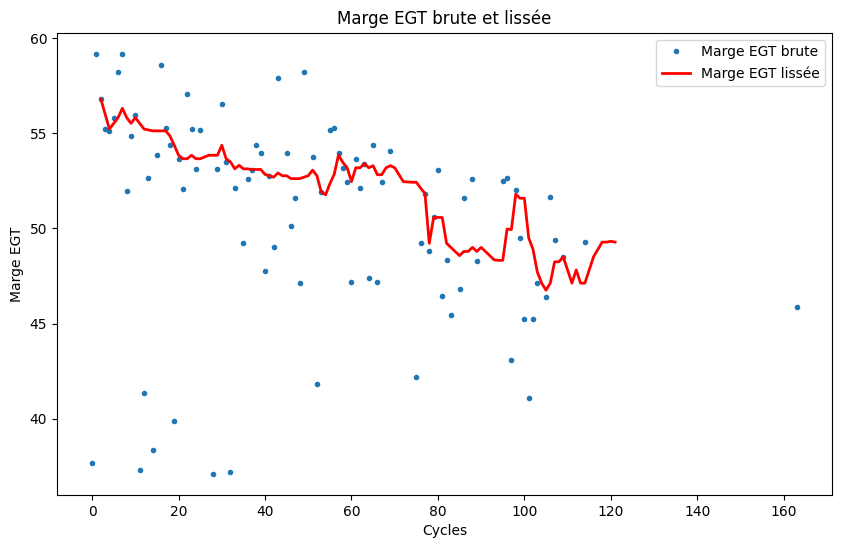

In [79]:
# série lissée ac fenêtre glissante de taille 15 cycles
egt_lisse = egt_reindexe.rolling(window=15, min_periods=3).median()

plt.figure(figsize=(10, 6))
plt.plot(egt_reindexe.index, egt_reindexe.values, marker='o', linestyle='', markersize=3, label='Marge EGT brute')
plt.plot(egt_lisse.index, egt_lisse.values, color='red', linewidth=2, label='Marge EGT lissée')
plt.xlabel('Cycles')
plt.ylabel('Marge EGT')
plt.legend()
plt.title('Marge EGT brute et lissée')
plt.show()


#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

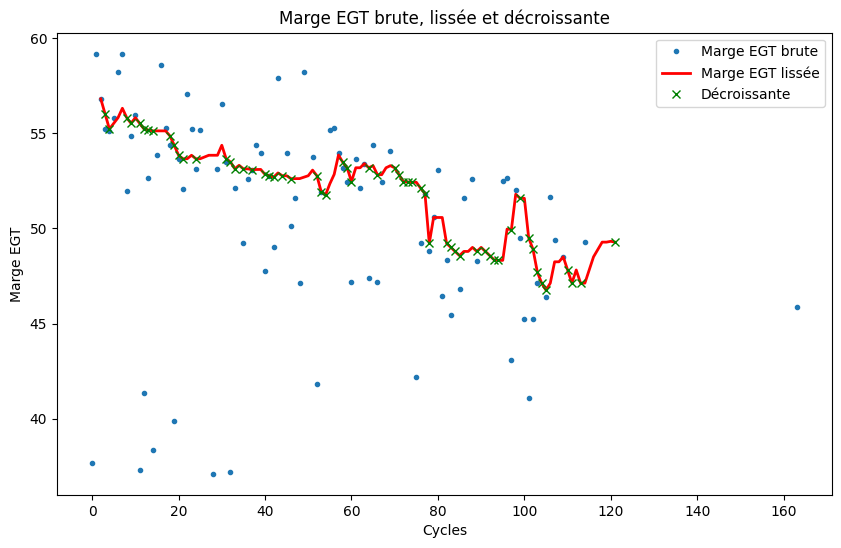

In [82]:
# Seulement les valeurs décroissantes de la marge EGT lissée
egt_decroissante = egt_lisse[egt_lisse.diff() < 0]

plt.figure(figsize=(10, 6))
plt.plot(egt_reindexe.index, egt_reindexe.values, marker='o', linestyle='', markersize=3, label='Marge EGT brute')
plt.plot(egt_lisse.index, egt_lisse.values, color='red', linewidth=2, label='Marge EGT lissée')
plt.plot(egt_decroissante.index, egt_decroissante.values, marker='x', color='green', linestyle='', markersize=6, label='Décroissante')
plt.xlabel('Cycles')
plt.ylabel('Marge EGT')
plt.legend()
plt.title('Marge EGT brute, lissée et décroissante')
plt.show()



#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [83]:
from sklearn.linear_model import LinearRegression

Coefficient de la pente (marge EGT) : -0.07144481713147227
Ordonnée à l'origine : 56.08465646797882


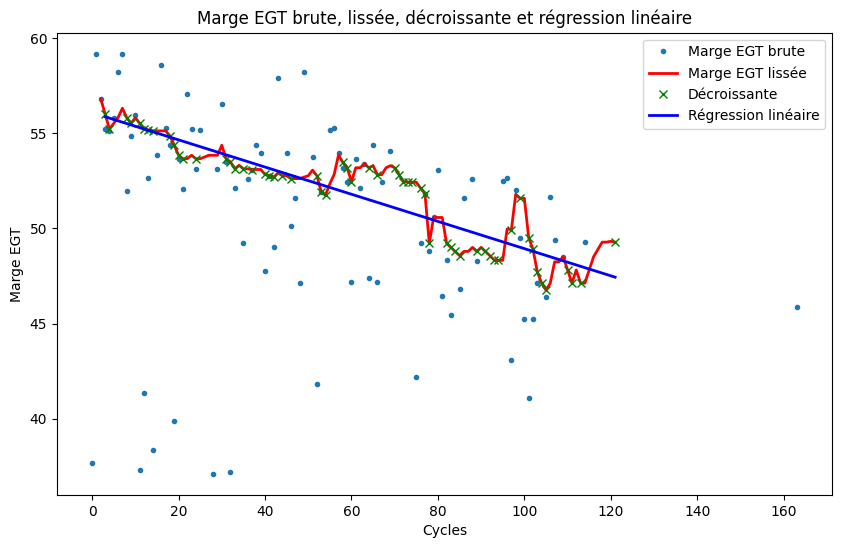

In [86]:
# Préparation des données pour la régression linéaire
X = np.array(egt_decroissante.index).reshape(-1, 1)  # Conversion en tableau 2D des index
y = np.array(egt_decroissante.values).reshape(-1, 1)  # idem pour des valeurs

# Création et apprentissage du modèle de régression linéaire
lr = LinearRegression()
lr.fit(X, y)

# Affichage des coefficients
print('Coefficient de la pente (marge EGT) :', lr.coef_[0][0])
print('Ordonnée à l\'origine :', lr.intercept_[0])


# Tracé des valeurs brutes, lissées et points décroissants sur le même graphe
plt.figure(figsize=(10, 6))
plt.plot(egt_reindexe.index, egt_reindexe.values, marker='o', linestyle='', markersize=3, label='Marge EGT brute')
plt.plot(egt_lisse.index, egt_lisse.values, color='red', linewidth=2, label='Marge EGT lissée')
plt.plot(egt_decroissante.index, egt_decroissante.values, marker='x', color='green', linestyle='', markersize=6, label='Décroissante')
plt.plot(X, lr.predict(X), color='blue', linewidth=2, label='Régression linéaire')
plt.xlabel('Cycles')
plt.ylabel('Marge EGT')
plt.legend()
plt.title('Marge EGT brute, lissée, décroissante et régression linéaire')
plt.show()


### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?